In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from ucimlrepo import fetch_ucirepo

import xgboost as xgb

##################
## Load the Dataset

adult = fetch_ucirepo(id=2) 

X = adult.data.features 
y = adult.data.targets 

# Create dataframe from uci
df = X.join(y)


##################
## Show data info

print('\n================== dataframe ==================')
display(df)

print('\n================== metadata ==================')
print(adult.metadata) 
  
print('\n================== variables ==================')
print(adult.variables)

print('\n================== info ==================')
print(df.info())



##################
## Data Cleaning

print('\n================== shape before cleaning ==================')
print(df.shape)

# Change '?' to NA so those rows can be dropped in the next step
df = df.replace('?', pd.NA)

# Drop rows containing NA
df = df.dropna()

print('\n================== shape after dropping NA ==================')
print(df.shape)

# 'education' is a redundant column
# 'education-num' is the ordinally encoded column representing 'education'
df = df.drop('education', axis=1)

# 'income' has different formats for its data
# fix this column to make it consistent
df['income'] = df['income'].replace('>50K.', '>50K')
df['income'] = df['income'].replace('<=50K.', '<=50K')

print('\n================== final shape after cleaning ==================')
print(df.shape)


##################
## Data Preprocessing

# Binarize Target Variable
df['income'] = np.where(df['income'] == '>50K', 1, 0)
df.rename(columns={'income':'income>50K'}, inplace=True)

# Show reformatted target variable
print('\n================== target variable column ==================')
display(df['income>50K'])

# Split features from target
y3 = df.iloc[:,-1:]
X3 = df.iloc[:,1:-1]

# Aggregration - marital-status
X3['marital-status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 'Married', inplace=True)
X3['marital-status'].replace(['Divorced', 'Separated', 'Widowed'], 'Divorced', inplace=True)

# Aggregration - workclass
X3['workclass'].replace(['Federal-gov', 'Local-gov', 'State-gov'], 'government', inplace=True)
X3['workclass'].replace(['Never-worked', 'Without-pay'], 'jobless', inplace=True)

# Aggregration - occupation
X3['occupation'].replace(['Tech-support', 'Craft-repair', 'Machine-op-inspct'], 'Technical/Support', inplace=True)
X3['occupation'].replace(['Other-service', 'Priv-house-serv', 'Protective-serv'], 'Service', inplace=True)
X3['occupation'].replace(['Exec-managerial', 'Adm-clerical'], 'Management/Administration', inplace=True)
X3['occupation'].replace(['Handlers-cleaners', 'Farming-fishing', 'Transport-moving'], 'Manual Labor', inplace=True)

# Aggregration - relationship
X3['relationship'].replace(['Wife', 'Husband'], 'Spouse', inplace=True)
X3['relationship'].replace(['Not-in-family', 'Unmarried'], 'Non-Family', inplace=True)

# Aggregration - native-country
X3['native-country'].replace(['United-States', 'Canada', 'Outlying-US(Guam-USVI-etc)'], 'North America', inplace=True)
X3['native-country'].replace(['England', 'Germany', 'Greece', 'Italy', 'Poland', 'Portugal', 'Ireland', 'France', 'Scotland', 'Yugoslavia', 'Hungary', 'Holand-Netherlands'], 'Europe', inplace=True)
X3['native-country'].replace(['Cambodia', 'India', 'Japan', 'China', 'Philippines', 'Vietnam', 'Taiwan', 'Laos', 'Iran', 'Thailand', 'Hong'], 'Asia', inplace=True)
X3['native-country'].replace(['Ecuador', 'Columbia', 'Peru','Puerto-Rico', 'Mexico', 'Cuba', 'Jamaica', 'Dominican-Republic', 'Haiti', 'Guatemala', 'Honduras', 'El-Salvador', 'Nicaragua', 'Trinadad&Tobago', 'Panama'], 'Central & South America', inplace=True)

# One-Hot-Encoding for categorical columns
X3 = pd.get_dummies(X3, columns=['marital-status'], dtype=int)
X3 = pd.get_dummies(X3, columns=['workclass'], dtype=int)
X3 = pd.get_dummies(X3, columns=['occupation'], dtype=int)
X3 = pd.get_dummies(X3, columns=['relationship'], dtype=int)
X3 = pd.get_dummies(X3, columns=['race'], dtype=int)
X3 = pd.get_dummies(X3, columns=['native-country'], dtype=int)

# Encode sex 1 or 0
X3['sex'] = np.where(X3['sex'] == 'Male', 1, 0)

print('\n================== features dataframe after preprocessing ==================')
display(X3.head())

print('\n================== features dataframe shape after preprocessing ==================')
print(X3.shape)


##################
## Classifier Implementation

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X3, np.ravel(y3), test_size=0.2, random_state=1)


================== dataframe ==================


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.



================== metadata ==================
{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was

0        0
1        0
2        0
3        0
4        0
        ..
48836    0
48837    0
48839    0
48840    0
48841    1
Name: income>50K, Length: 45222, dtype: int32


================== features dataframe after preprocessing ==================


,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,marital-status_Divorced,marital-status_Married,marital-status_Never-married,workclass_Private,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,native-country_Asia,native-country_Central & South America,native-country_Europe,native-country_North America,native-country_South
0,77516,13,1,2174,0,40,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,83311,13,1,0,0,13,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,215646,9,1,0,0,40,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,234721,7,1,0,0,40,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0
4,338409,13,0,0,0,40,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0



================== features dataframe shape after preprocessing ==================
(45222, 35)


In [7]:
##################
## Logistic Regression

print('\n================== Logistic Regression ==================')
print('\n======================================================')

# Create a pipeline that standardizes the data then creates a Logistic Regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),               # Feature scaling
    ('logreg', LogisticRegression(max_iter=1000))  # Logistic Regression classifier
])

# Define the parameter grid
param_grid = {
    'logreg__C': np.logspace(-4, 4, 20),               # Regularization strength
    'logreg__solver': ['liblinear', 'lbfgs'],  # Solvers
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print('\n================== Best parameters found ==================')
print(grid_search.best_params_)

# Evaluate the best model found by GridSearchCV on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print('\n================== test accuracy ==================')
print(test_accuracy)
y_pred = best_model.predict(X_test)

# Print Confusion Matrix
print('\n================== confusion matrix ==================')
print(confusion_matrix(y_test, y_pred))

# Print Classification Report
print('\n================== classification report ==================')
print(classification_report(y_test, y_pred))

# Get the coefficients of the features from the logistic regression model within the pipeline
feature_importances = best_model.named_steps['logreg'].coef_[0]

# Print feature names and their coefficients
print('\n================== feature importance ==================')
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")



================== Logistic Regression ==================

Fitting 5 folds for each of 40 candidates, totalling 200 fits

================== Best parameters found ==================
{'logreg__C': 0.23357214690901212, 'logreg__solver': 'liblinear'}

================== test accuracy ==================
0.8411276948590382

================== confusion matrix ==================
[[6309  477]
 [ 960 1299]]

================== classification report ==================
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6786
           1       0.73      0.58      0.64      2259

    accuracy                           0.84      9045
   macro avg       0.80      0.75      0.77      9045
weighted avg       0.83      0.84      0.83      9045


================== feature importance ==================
fnlwgt: 0.06495223986378894
education-num: 0.7391968883330544
sex: 0.1568291498103814
capital-gain: 2.3260635421769136
capital-loss: 0.271537436804209

In [8]:
##################
## Decision Tree
    
print('\n================== Decision Tree ==================')
print('\n======================================================')

# Create a pipeline that standardizes the data then creates a Decision Tree model
pipeline = Pipeline([
    ('dtree', DecisionTreeClassifier())  # Decision Tree classifier
])

# Define the parameter grid
param_grid = {
    'dtree__max_depth': np.arange(3, 16),  
    'dtree__min_samples_split': [2, 5, 10, 20],         
    'dtree__criterion': ['gini', 'entropy']             
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print('\n================== Best parameters found ==================')
print(grid_search.best_params_)

# Evaluate the best model found by GridSearchCV on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print('\n================== test accuracy ==================')
print(test_accuracy)
y_pred = best_model.predict(X_test)

# Print Confusion Matrix
print('\n================== confusion matrix ==================')
print(confusion_matrix(y_test, y_pred))

# Print Classification Report
print('\n================== classification report ==================')
print(classification_report(y_test, y_pred))

feature_importances = best_model.named_steps['dtree'].feature_importances_

# Print feature names and their importances
print('\n================== feature importance ==================')

for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")


================== Decision Tree ==================

Fitting 5 folds for each of 104 candidates, totalling 520 fits

================== Best parameters found ==================
{'dtree__criterion': 'gini', 'dtree__max_depth': 8, 'dtree__min_samples_split': 20}

================== test accuracy ==================
0.8504145936981757

================== confusion matrix ==================
[[6488  298]
 [1055 1204]]

================== classification report ==================
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6786
           1       0.80      0.53      0.64      2259

    accuracy                           0.85      9045
   macro avg       0.83      0.74      0.77      9045
weighted avg       0.85      0.85      0.84      9045


================== feature importance ==================
fnlwgt: 0.002302066137905744
education-num: 0.23105353815093316
sex: 0.00343078729250043
capital-gain: 0.20591005086636754
capital-loss: 

In [9]:
##################
## Random Forest Classifier

print('\n================== Random Forest Classifier ==================')
print('\n======================================================')

# Create a pipeline that standardizes the data then creates a Random Forest Classifier model
pipeline = Pipeline([
    ('rf', RandomForestClassifier())
])

# Define the parameter grid
param_grid = {
    'rf__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'rf__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print('\n================== Best parameters found ==================')
print(grid_search.best_params_)

# Evaluate the best model found by GridSearchCV on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print('\n================== test accuracy ==================')
print(test_accuracy)

y_pred = best_model.predict(X_test)

# Print Confusion Matrix
print('\n================== confusion matrix ==================')
print(confusion_matrix(y_test, y_pred))

# Print Classification Report
print('\n================== classification report ==================')
print(classification_report(y_test, y_pred))

# Get the feature importances from the Random Forest model within the pipeline
feature_importances = best_model.named_steps['rf'].feature_importances_

# Print feature names and their importances
print('\n================== Feature Importance ==================')
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")


================== Random Forest Classifier ==================

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [19]:
##################
## Support Vector Machine Classifier

print('\n================== Support Vector Machine Classifier ==================')
print('\n======================================================')

# Create a pipeline that standardizes the data then creates a SVM model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # It's crucial to scale data for SVM
    ('svm', SVC())
])

# Define the parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10],  # Regularization parameter
    'svm__kernel': ['linear', 'rbf', 'poly'],  # Type of kernel
    'svm__degree': [2, 3, 4],  # Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
    'svm__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Assuming X_train, y_train, X_test, y_test are predefined
# as your training and testing datasets respectively

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print('\n================== Best parameters found ==================')
print(grid_search.best_params_)

# Evaluate the best model found by GridSearchCV on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print('\n================== test accuracy ==================')
print(test_accuracy)

y_pred = best_model.predict(X_test)

# Print Confusion Matrix
print('\n================== confusion matrix ==================')
print(confusion_matrix(y_test, y_pred))

# Print Classification Report
print('\n================== classification report ==================')
print(classification_report(y_test, y_pred))



================== Support Vector Machine Classifier ==================

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\jason\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jason\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jason\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jason\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

KeyboardInterrupt: 

In [22]:
# Initialize the XGBClassifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of a tree
    'colsample_bytree': [0.7, 0.8],  # Subsample ratio of columns when constructing each tree
    'subsample': [0.7, 0.8]  # Subsample ratio of the training instances
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Evaluate the best model found by GridSearchCV on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print('\n================== test accuracy ==================')
print(test_accuracy)

# Print Confusion Matrix
print('\n================== confusion matrix ==================')
print(confusion_matrix(y_test, y_pred))

# Print Classification Report
print('\n================== classification report ==================')
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

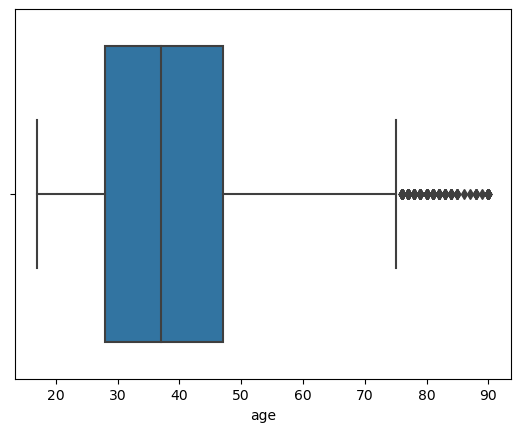

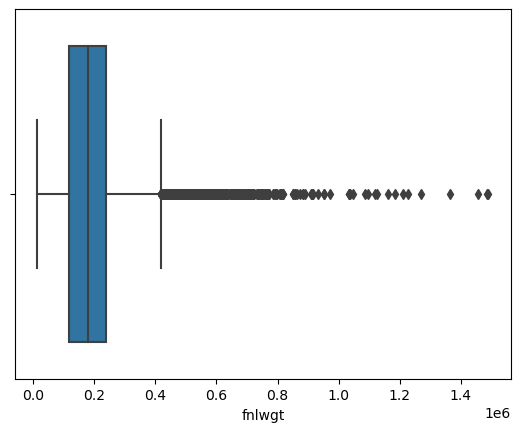

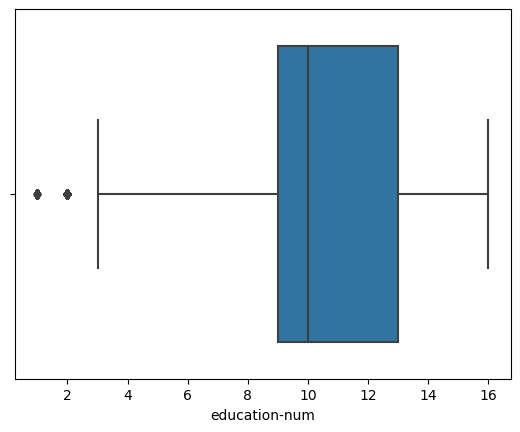

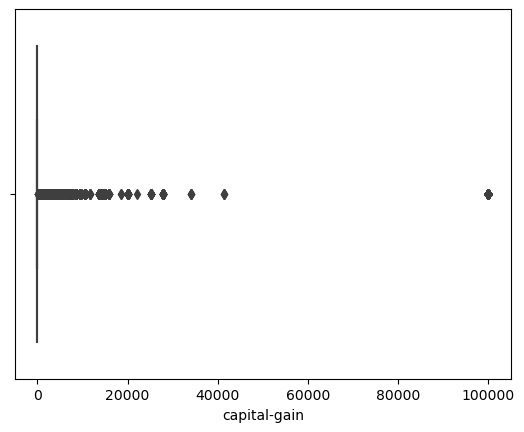

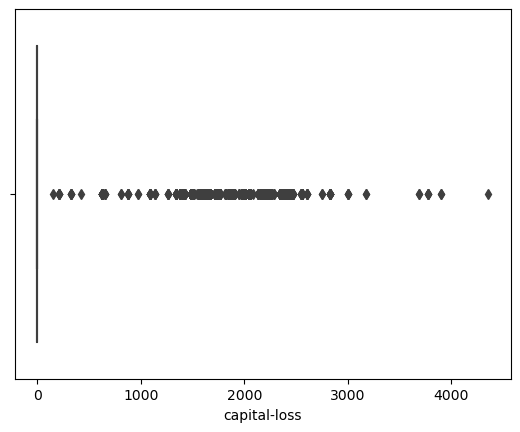

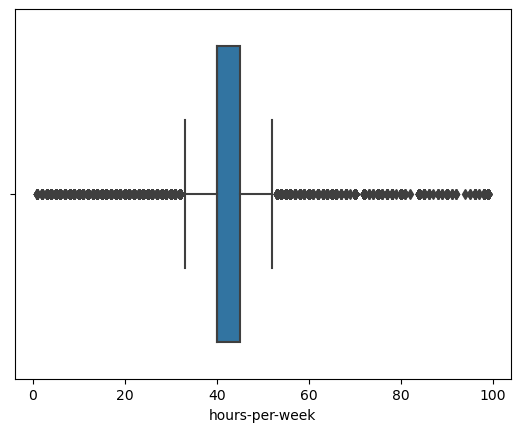

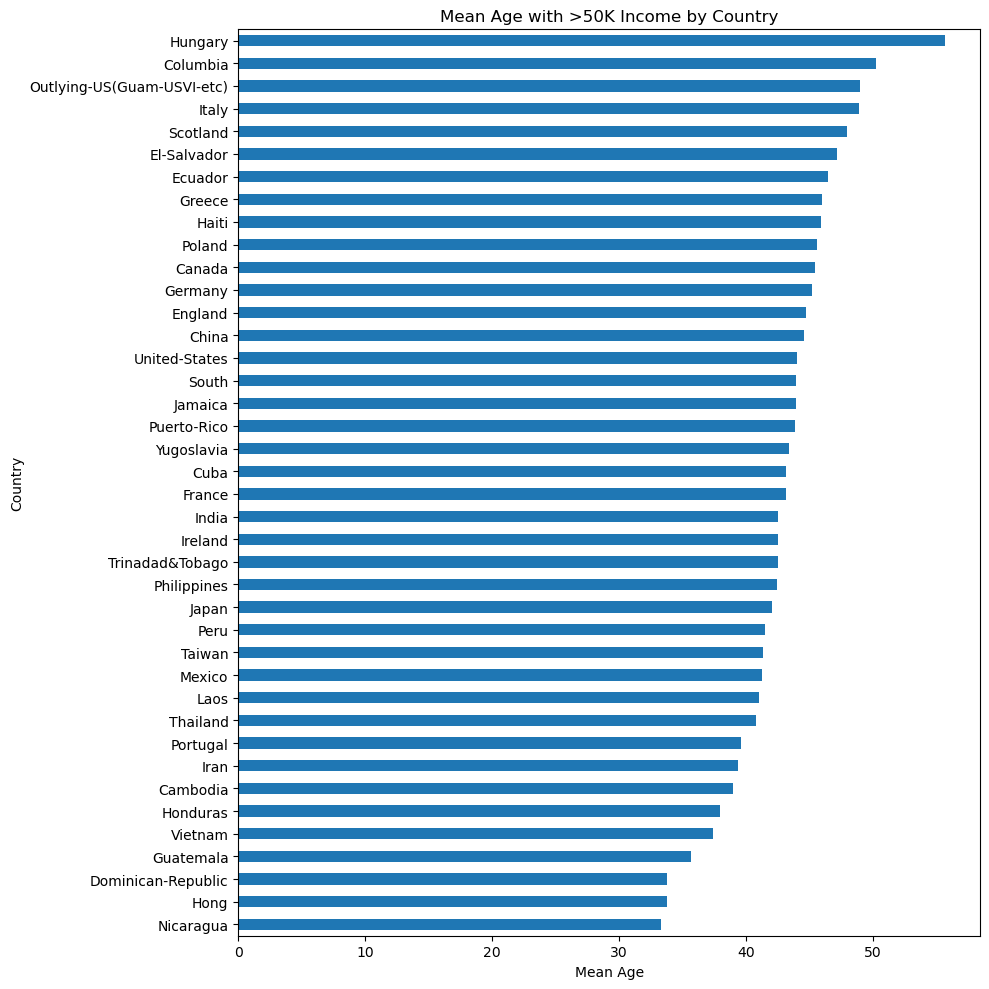

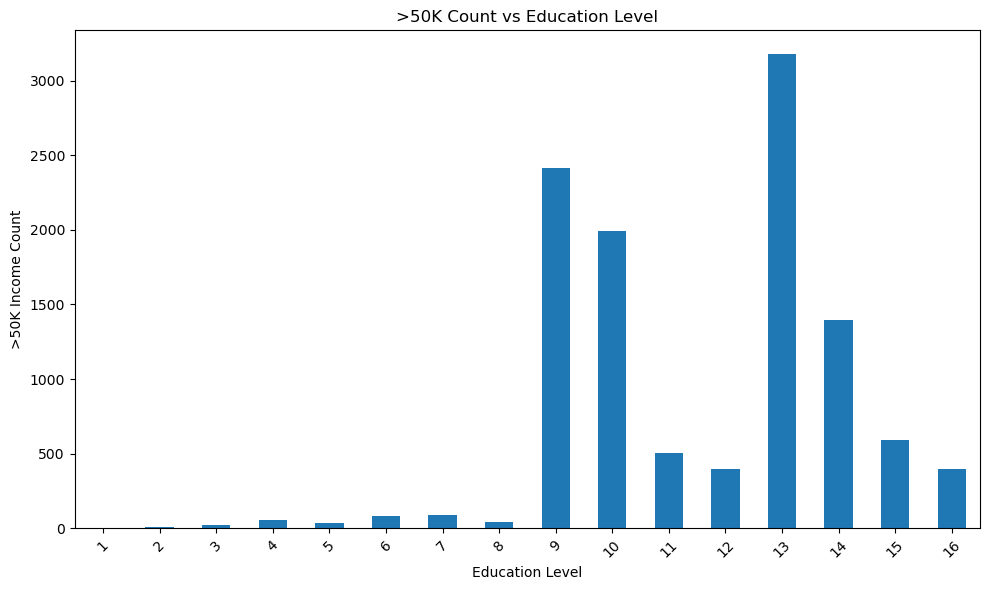

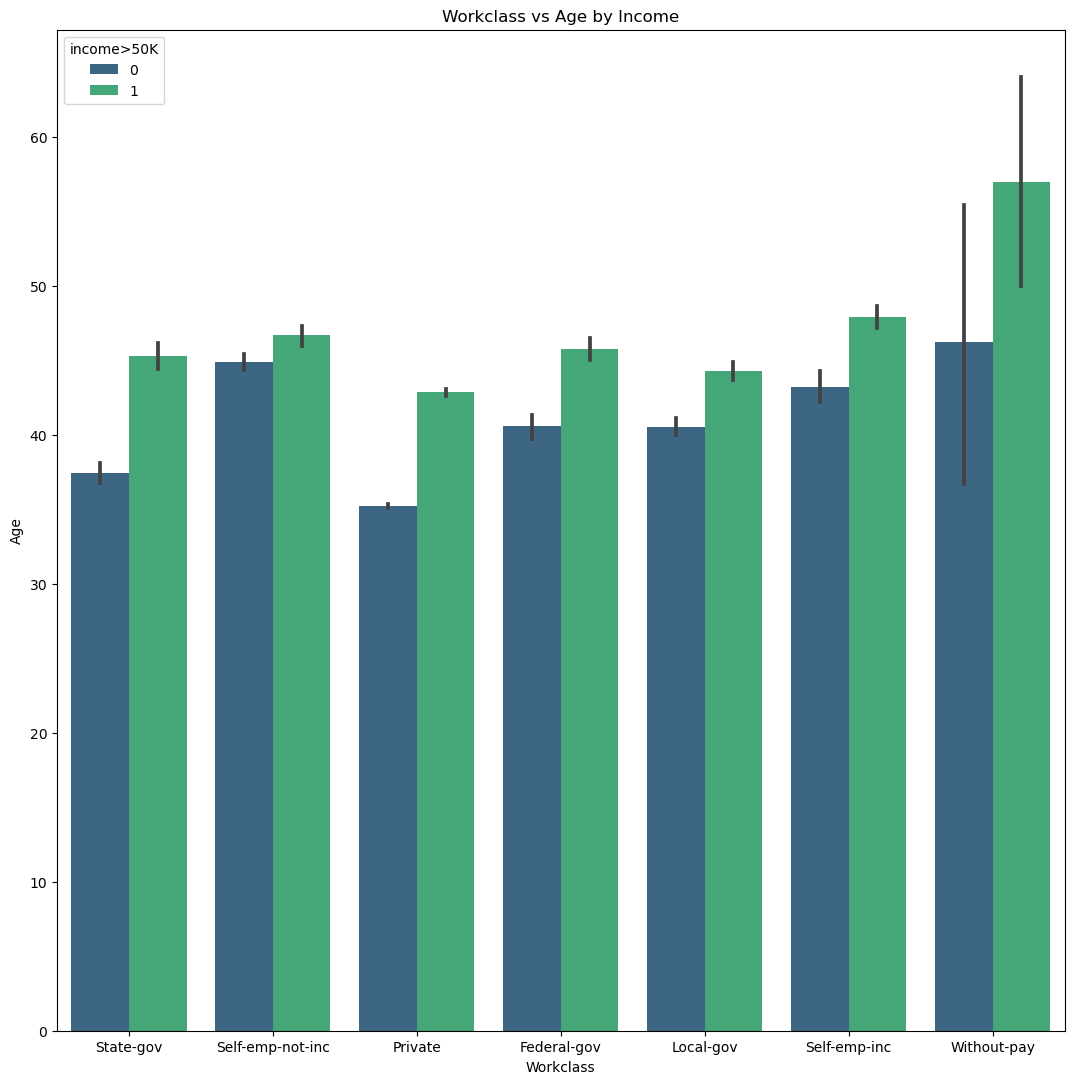

In [28]:
int_columns = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
for i in int_columns:
  sns.boxplot(x = df[i])
  plt.show()

  high_income_df = df[df['income>50K'] == 1]

# Group by country and calculate mean age
mean_age_by_country = high_income_df.groupby('native-country')['age'].mean().sort_values()

# Plotting
plt.figure(figsize=(10, 10))
mean_age_by_country.plot(kind='barh')
plt.title('Mean Age with >50K Income by Country')
plt.xlabel('Mean Age')
plt.ylabel('Country')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))

income_count_by_education = high_income_df['education-num'].value_counts().sort_index()
income_count_by_education.plot(kind='bar')
plt.title('>50K Count vs Education Level')
plt.xlabel('Education Level')
plt.ylabel('>50K Income Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


# Plotting
plt.figure(figsize=(13, 13))
sns.barplot(x="workclass", y="age", hue='income>50K', data=df, palette="viridis")
plt.xlabel("Workclass")
plt.ylabel("Age")
plt.title("Workclass vs Age by Income")
plt.show()